# Academic access for Twitter API v2


You can apply for academic access using [this page](https://developer.twitter.com/en/portal/petition/academic/is-it-right-for-you). More information about the application process is available at [this link](https://developer.twitter.com/en/products/twitter-api/academic-research/application-info).

One challenge is that you must list a public student profile page associated with Penn. My best recommendation is to list the [public Penn directory](https://directory.apps.upenn.edu/directory/jsp/fast.do) and then make sure the name listed on the application matches your name in the directory so that they will be able to search for you.

Once you have academic access you should see "ACADEMIC" listed on https://developer.twitter.com/en/portal/dashboard.

<div>
    <img src="imgs/twitter-api-1.png" width=500/>
</div>

With academic access in v2, the new limits for the search API are significantly more than permissive than with v1 access. There are two search endpoints:

1. `client.search_recent_tweets()` [docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_recent_tweets): Search one recent tweets within the last 7 days, 
1. `client.search_all_tweets()` [docs](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets): Search all historical tweets going back to 2006. 

<div>
    <img src="imgs/twitter-api-2.png" width=700 />
</div>

For historical search, you are allowed 300 requests per every 15 minutes, and can access 500 tweets per requests, so you can pull 150,000 tweets per every 15 minutes. The required wait time between requests is one second. 

## Major Changes

By default, only the text and tweet id are returned by Tweepy. You can request more fields using the "tweet_fields" keyword. Available attributes are listed [on the documentation](https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet). Below, we add the "created_at" field to capture when the tweets were created.

There are also two new functions: `get_all_tweets_count()` and `get_recent_tweets_count()` which return the total tweet count with a specified frequency, e.g., daily, monthly, etc. for the tweets that match the input query.

The operators in the search query string have also changed, see [the documentation](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product) for examples.

The `tw.Cursor` object has been renamed to the `tw.Paginator` class in v2. 

## References

- [Tutorial on tweepy with v2 API](https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9) -- **very good tutorial, definitely read this**
- [Twitter search API documentation](https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction)
- [Search query operators](https://developer.twitter.com/en/docs/twitter-api/enterprise/rules-and-filtering/operators-by-product)

## Important: Update your musa-550-fall-2021 environment

To use the v2 API, we'll need the latest version of tweepy. You can update your course environment using the [instructions on the course website](https://musa-550-fall-2021.github.io/guides/conda#updating-an-existing-environment).

From the command line run, 

```
conda env update pennmusa/musa-550-fall-2021
```

In [1]:
import tweepy as tw
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import calendar

In [2]:
print(tw.__version__) # Make sure this is > 4.0

4.4.0


In [3]:
# Get this from the app that you create on the developer portal
BEARER_TOKEN = "REPLACE ME"

In [4]:
# Initialize the API client and tell tweepy to wait if rate limit is met
client = tw.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True)

## 1. Historical tweets for a specified time period

Below, we select all tweets with the hashtag "phillies" during calendar year 2020 and exclude any retweets.

In [5]:
# Search for phillies hashtag and remove retweets
query = "#phillies -is:retweet" # remove retweets using hypen

# Example start and end date
start_date = datetime.strptime("2020-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2020-12-31", "%Y-%m-%d")

In [6]:
results = []
max_results_per_request = 500 # must be between 10 and 500

# Use the paginator to loop over all available tweets in batches of 500
# This pulls 500 tweets at a time until all tweets from the time period are pulled
for i, tweets in enumerate(
    tw.Paginator(
        client.search_all_tweets,
        query=query,
        tweet_fields=["created_at"], # Request additional fields 
        max_results=max_results_per_request,
        start_time=start_date,
        end_time=end_date,
        # limit = 10000 # Optional maximum limit to be returned
    )
):
        
    # Log each time a new request is made
    print(f"Request #{i}")
    
    # Saves all of the tweets 
    results += tweets.data
            
    # Sleep for 1 second to avoid rate limit
    time.sleep(1)

Request #0


KeyboardInterrupt: 

In [119]:
# Convert to a dataframe and make a datetime column
results = pd.DataFrame(results)
results['created_at'] = pd.to_datetime(results['created_at'])

In [223]:
len(results)

86792

In [122]:
results.head()

,created_at,id,text,withheld
0,2020-12-30 23:48:27+00:00,1344430178311745536,The reason Carson Wentz &amp; Bryce Harper get...,NaN
1,2020-12-30 23:30:15+00:00,1344425598777610241,#MLB 2020 Year In Review\n\nPitch Quality Lead...,NaN
2,2020-12-30 22:58:24+00:00,1344417581361410051,#Phillies fans might be feeling déjà vu when c...,NaN
3,2020-12-30 22:58:19+00:00,1344417561417560064,#Phillies fans might be feeling déjà vu when c...,NaN
4,2020-12-30 22:33:51+00:00,1344411405932494852,The latest Left-Handed News! https://t.co/xhPI...,NaN


Plot the monthly tweet counts:

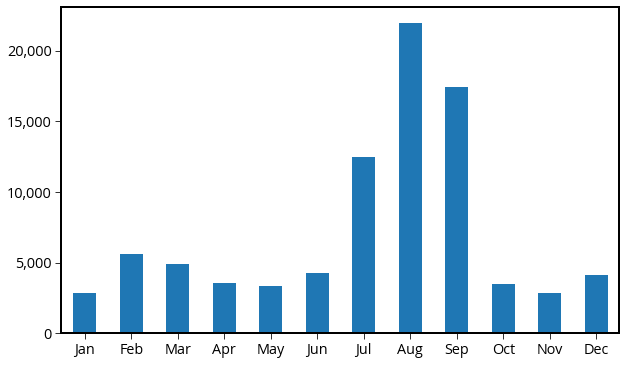

In [156]:
# Calculate monthly tweet totals
monthly_count = results['created_at'].dt.month.value_counts().sort_index()

# Initialize the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot
monthly_count.plot(kind='bar', ax=ax)

# Format
ax.set_xticks(range(0, 12))
ax.set_xticklabels([calendar.month_abbr[v] for v in range(1, 13)], rotation=0);
ax.set_yticks(np.arange(0, 25e3, 5e3))
ax.set_yticklabels([f"{v:,.0f}" for v in ax.get_yticks()]);

## 2. Filtering tweets by location

For more information, see this [tutorial](https://developer.twitter.com/en/docs/tutorials/filtering-tweets-by-location) on the Twitter documentation. Specifically, this tutorial includes [a number of examples](https://developer.twitter.com/en/docs/tutorials/filtering-tweets-by-location#usage-examples).

### 2A. Get tweets associated with a specific place

This will get all tweets geo-tagged as in Philadelphia.

To do this, use the `place` operator.

In [188]:
query = "#phillies -is:retweet place:Philadelphia"

tweets = client.search_all_tweets(
    query=query,
    tweet_fields=["created_at", "geo"],
    place_fields=["place_type", "geo"],
    expansions="geo.place_id",
    max_results=10,
)

# Get list of places from includes object
places = {p["id"]: p for p in tweets.includes['places']}

# Print out info
for tweet in tweets.data:
    print(tweet.id)
    print(tweet.text)
    if places[tweet.geo['place_id']]:
        place = places[tweet.geo['place_id']]
        print(place.full_name)
        
    print()

1468266278611738624
“I ain’t an athlete, lady” - John Kruk ⚾️ 
.
https://t.co/VMh2r5nYVi
.
#Phillies #Philly #Phila #PhiladelphiaPhillies #Johnkruk @ Philadelphia, Pennsylvania https://t.co/Ax4RxuDI1N
Philadelphia, PA

1466388965137727494
The good thing about the #mlblockout is that I don't have to refresh my feed every five minutes and be disappointed in the lack of #Phillies moves.
Philadelphia, PA

1465893956340879363
William James (not Bill) understands what the #Phillies are choosing.
Philadelphia, PA

1465730094312443904
When you see that the #Phillies signed someone and your heart starts pounding, then you see who it is and that same heart breaks. https://t.co/KOzB1dClvO
Philadelphia, PA

1465577041667964935
RUMOR: #Phillies y RP COREY KNEBEL
En avanzadas negociaciones, el ex-relevista de los #Dodgers y Cerrador de #Brewers 
Es un gran competidor con 2 excelentes pitcheos una Recta 97 MPH (58%) y una de los mejores knuckle curves 80 MPH (41%) de #MLB 
https://t.co/ggJ5qBoTQM
Phi

In [177]:
tweets.data[0].data

{'text': '“I ain’t an athlete, lady” - John Kruk ⚾️ \n.\nhttps://t.co/VMh2r5nYVi\n.\n#Phillies #Philly #Phila #PhiladelphiaPhillies #Johnkruk @ Philadelphia, Pennsylvania https://t.co/Ax4RxuDI1N',
 'created_at': '2021-12-07T17:08:54.000Z',
 'id': '1468266278611738624',
 'geo': {'coordinates': {'type': 'Point', 'coordinates': [-75.1651, 39.9527]},
  'place_id': 'e4a0d228eb6be76b'}}

### 2B. Search within a given radius 

This will get all tweets within 25 milies of the centroid of Philadelphia. 

To do this, use the `point_radius` operator. **Note:** maximum radius is 25 miles.

In [190]:
query = "#phillies -is:retweet point_radius:[-75.1651 39.9527 25mi]"

tweets = client.search_all_tweets(
    query=query,
    tweet_fields=["created_at", "geo"],
    place_fields=["place_type", "geo"],
    expansions="geo.place_id",
    max_results=10,
)

# Get list of places from includes object
places = {p["id"]: p for p in tweets.includes['places']}

# Print out info for each tweet
for tweet in tweets.data:
    
    # Print out the tweet info
    print(tweet.id)
    print(tweet.text)
    
    # Print out the place name
    if places[tweet.geo['place_id']]:
        place = places[tweet.geo['place_id']]
        print(place.full_name)
        
    print()

1468266278611738624
“I ain’t an athlete, lady” - John Kruk ⚾️ 
.
https://t.co/VMh2r5nYVi
.
#Phillies #Philly #Phila #PhiladelphiaPhillies #Johnkruk @ Philadelphia, Pennsylvania https://t.co/Ax4RxuDI1N
Philadelphia, PA

1467843105671892999
I made some new friends after the game yesterday by joining these guys on their podcast.  Fun conversation about the game and some quick baseball hits at the end!   #TakeFlight #FlyEaglesFly #Phillies https://t.co/jhiVD4EM7u
Marlton, NJ

1467126878087663623
#PhilliesHolidays READY at @PhilliesCBP!! #Phillies https://t.co/VtJgo9L9N3
New Era Phillies Team Store

1466388965137727494
The good thing about the #mlblockout is that I don't have to refresh my feed every five minutes and be disappointed in the lack of #Phillies moves.
Philadelphia, PA

1466142960924381200
about damn time #Phillies 😁 #RingTheBell https://t.co/1x7oA9O5x2
Drexel Hill, PA

1466008870212489218
The @Phillies have been _______  quiet, so far in Free agency…  #Phillies #MLBFreeAgency
O

In [191]:
places

{'e4a0d228eb6be76b': <Place id=e4a0d228eb6be76b full_name=Philadelphia, PA>,
 '860637a8dc169e00': <Place id=860637a8dc169e00 full_name=Marlton, NJ>,
 '11c9f1929c94f000': <Place id=11c9f1929c94f000 full_name=New Era Phillies Team Store>,
 '4eaabc683e109220': <Place id=4eaabc683e109220 full_name=Drexel Hill, PA>,
 '9095689305b0d9f2': <Place id=9095689305b0d9f2 full_name=Oaklyn, NJ>,
 '9b977bdde8553e88': <Place id=9b977bdde8553e88 full_name=Horsham, PA>}

**Note:** to get more than 500 tweets, you must use the Paginator class.

In [193]:
# Convert to a dataframe and make a datetime column
geo_results = pd.DataFrame(geo_results)
geo_results['created_at'] = pd.to_datetime(geo_results['created_at'])

In [194]:
geo_results.head()

,created_at,geo,text,id
0,2020-12-29 02:12:49+00:00,{'place_id': '4ebcf64484051ec2'},@irockphilly @tbrax_sr @FranzkeLA That was dur...,1343741735223128064
1,2020-12-28 15:22:22+00:00,{'place_id': 'e4a0d228eb6be76b'},@jerryd1426 @philliesbell @Phillies @ColeHamel...,1343578043844059137
2,2020-12-27 22:05:30+00:00,{'place_id': '4ebcf64484051ec2'},The #Phillies starting pitcher the day DeSean ...,1343317104968294400
3,2020-12-26 19:28:30+00:00,{'place_id': 'e4a0d228eb6be76b'},@philliesbell @Phillies @Cubs Great trade for ...,1342915208336060416
4,2020-12-24 01:53:43+00:00,{'place_id': '4ebcf64484051ec2'},Maxey making a push to be the best #0 in town ...,1341924989348536321


### 2C. Geo search with Paginator

In [7]:
query_results = []
places = {}
max_results_per_request = 500 # must be between 10 and 500

# Use the paginator to loop over all available tweets in batches of 500
# This pulls 500 tweets at a time until all tweets from the time period are pulled
for i, tweets in enumerate(
    tw.Paginator(
        client.search_all_tweets,
        query="#phillies -is:retweet point_radius:[-75.1651 39.9527 25mi]",
        tweet_fields=["created_at", "geo"],
        place_fields=["place_type", "geo"],
        expansions="geo.place_id",
        max_results=max_results_per_request,
        start_time=start_date,
        end_time=end_date,
        limit=10
    )
):
    print(f"Response #{i+1}")
    
    # Store the tweet data
    # Note: 'tweets.data' is a list of the 500 tweets
    query_results += tweets.data
    
    # Keep track of all of the places
    for p in tweets.includes['places']:
        places[p["id"]] = p
   
    # Sleep for 1 second to avoid rate limit
    time.sleep(1)

Response #1
Response #2
Response #3
Response #4


In [8]:
# Convert to a dataframe and make a datetime column
query_results = pd.DataFrame(query_results)
query_results['created_at'] = pd.to_datetime(query_results['created_at'])

# Extract out the place id as its own column
query_results['place_id'] = query_results['geo'].apply(lambda geo: geo['place_id'])

In [17]:
# Convert places dict to a dataframe
places_df = []

# Loop over each place_id
for place_id in places:
    
    # Geo info for each place
    values = places[place_id]
    
    # Convert to a dict
    row = dict(values)
    
    # Save it
    places_df.append(row)
    
# Initialize the dataframe
places_df = pd.DataFrame(places_df).rename(columns={"id": "place_id"})

In [18]:
places_df.head()

,full_name,geo,place_id,place_type
0,"Penndel, PA","{'type': 'Feature', 'bbox': [-74.924109, 40.14...",4ebcf64484051ec2,city
1,"Philadelphia, PA","{'type': 'Feature', 'bbox': [-75.280284, 39.87...",e4a0d228eb6be76b,city
2,"Levittown, PA","{'type': 'Feature', 'bbox': [-74.898856, 40.12...",36561e80ad680e74,city
3,"Drexel Hill, PA","{'type': 'Feature', 'bbox': [-75.331497, 39.91...",4eaabc683e109220,city
4,"West Norriton, PA","{'type': 'Feature', 'bbox': [-75.423883, 40.10...",4e8e8d528cc56580,city


In [19]:
# Merge in the places geo data and the query results
query_results_final = query_results.merge(places_df, how='left', on='place_id')

In [20]:
query_results_final.head()

,created_at,geo_x,id,text,place_id,full_name,geo_y,place_type
0,2020-12-29 02:12:49+00:00,{'place_id': '4ebcf64484051ec2'},1343741735223128064,@irockphilly @tbrax_sr @FranzkeLA That was dur...,4ebcf64484051ec2,"Penndel, PA","{'type': 'Feature', 'bbox': [-74.924109, 40.14...",city
1,2020-12-28 15:22:22+00:00,{'place_id': 'e4a0d228eb6be76b'},1343578043844059137,@jerryd1426 @philliesbell @Phillies @ColeHamel...,e4a0d228eb6be76b,"Philadelphia, PA","{'type': 'Feature', 'bbox': [-75.280284, 39.87...",city
2,2020-12-27 22:05:30+00:00,{'place_id': '4ebcf64484051ec2'},1343317104968294400,The #Phillies starting pitcher the day DeSean ...,4ebcf64484051ec2,"Penndel, PA","{'type': 'Feature', 'bbox': [-74.924109, 40.14...",city
3,2020-12-26 19:28:30+00:00,{'place_id': 'e4a0d228eb6be76b'},1342915208336060416,@philliesbell @Phillies @Cubs Great trade for ...,e4a0d228eb6be76b,"Philadelphia, PA","{'type': 'Feature', 'bbox': [-75.280284, 39.87...",city
4,2020-12-24 01:53:43+00:00,{'place_id': '4ebcf64484051ec2'},1341924989348536321,Maxey making a push to be the best #0 in town ...,4ebcf64484051ec2,"Penndel, PA","{'type': 'Feature', 'bbox': [-74.924109, 40.14...",city
